In [10]:
"""
NLP from scratch: Classifying names with a character-level RNN and LSTM
"""
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import torch

import torch.nn as nn
import torch.optim as optim

In [2]:
"""
Step 1. Preparing the data
"""

def findFiles(path): 
    return glob.glob(path)

path = '/home/song/Downloads/Project3_code_and_data/data/names/'
print(findFiles(path+'*.txt'))

['/home/song/Downloads/Project3_code_and_data/data/names/Chinese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Portuguese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/German.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Czech.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Korean.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Dutch.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Arabic.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Greek.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Japanese.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Irish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Russian.txt', '/home/song/Downloads/Project3_code_and_data/data/names/French.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Polish.txt', '/home/song/Downloads/Project3_code_and_data/data/names/Spanish.txt', '/home/song/Downloads/Projec

In [3]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#  Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

#  Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

#  Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path+'*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

#  Now we have category_lines, a dictionary mapping each category (language) to a 
#list of lines (names). We also kept track of all_categories (just a list of 
#languages) and n_categories for later reference.


Slusarski
18


In [4]:
"""
Step 2. Turning names into tensors
"""
#  Now that we have all names organized, we need to turn them into Tensors to make 
#any use of them. To represent a single letter, we use a ``one-hot vector'' of size 
#<1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the 
#current letter, e.g. "b" = <0 1 0 0 0 ...>
#  To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>
#The extra 1 dimension is because PyTorch assumes everything is in batches -- we're
#just using a batch size of 1 here.
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [8]:
"""
Repeat the above steps with the LSTM model
"""

class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(LSTM,self).__init__()
        self.hidden_size = hidden_size

        self.LSTM = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=False,
        )
        self.linear = nn.Linear(hidden_size, output_size)
        #self.softmax = nn.LogSoftmax(dim=1)
    def forward(self,x):
        lstm,_ = self.LSTM(x) 
        out = self.linear(lstm[-1, :, :])
        #output =self.softmax(out)
        return out

n_hidden = 128
lstm = LSTM(n_letters, n_hidden, n_categories)
#criterion = nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

learning_rate = 0.005 # If this is too high, it might explode. If too low, it might not learn

def train_lstm(category_tensor, line_tensor):
    lstm.zero_grad()

    #for i in range(line_tensor.size()[0]):
    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Adding parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [15]:
import random
import time
import math

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keeping track of losses for plotting
current_loss = 0
lstm_losses = []

optimizer = optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.1)

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def randomTrainingExample():
    category = random.choice(all_categories)
    while category not in category_lines or len(category_lines[category]) == 0:
        category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss
    optimizer.zero_grad()

    # Converting the loss to a tensor
    loss_tensor = torch.tensor(loss, requires_grad=True)

    # Calling backward on the loss tensor
    loss_tensor.backward()

    optimizer.step()
    scheduler.step()

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Adding current loss avg to list of losses
    if iter % plot_every == 0:
        lstm_losses.append(current_loss / plot_every)
        current_loss = 0

('Irish', 9)
5000 5% (0m 12s) 0.6716 Shim / Korean ✓
10000 10% (0m 25s) 0.0823 Tzeboev / Russian ✓
15000 15% (0m 39s) 0.2381 Byon / Korean ✓
20000 20% (0m 52s) 1.2240 Swatchak / Polish ✗ (Czech)
25000 25% (1m 5s) 0.9871 Saji / Japanese ✓
30000 30% (1m 17s) 2.4650 Ruvelas / French ✗ (Greek)
35000 35% (1m 30s) 0.0018 Desyatchikov / Russian ✓
40000 40% (1m 44s) 2.7336 Harger / German ✗ (Czech)
45000 45% (1m 56s) 0.1665 Paimukhin / Russian ✓
50000 50% (2m 9s) 0.3986 Jo / Korean ✓
55000 55% (2m 22s) 0.0026 Kotsiopoulos / Greek ✓
60000 60% (2m 35s) 3.1472 Watt / Scottish ✗ (English)
65000 65% (2m 47s) 0.2888 Fukao / Japanese ✓
70000 70% (2m 59s) 1.5101 Yeates / Dutch ✗ (English)
75000 75% (3m 12s) 3.3831 Lyon / Korean ✗ (French)
80000 80% (3m 26s) 0.9084 Filipek / Czech ✗ (Polish)
85000 85% (3m 38s) 0.4395 Arena / Spanish ✓
90000 90% (3m 50s) 0.0163 Tsukioka / Japanese ✓
95000 95% (4m 1s) 1.0365 Joe / Korean ✗ (Chinese)
100000 100% (4m 13s) 1.0959 Costa / Spanish ✗ (Portuguese)


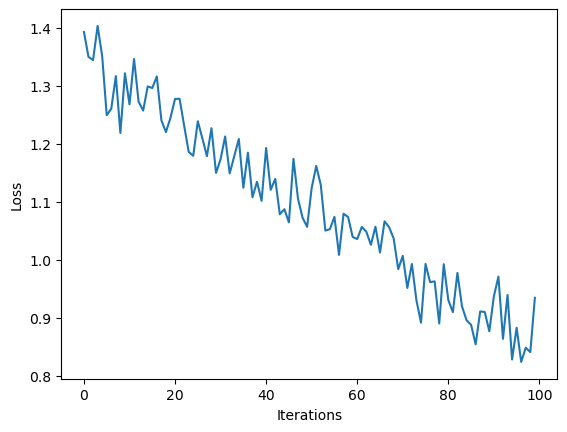

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(lstm_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

/tmp/ipykernel_14714/901265761.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories)
/tmp/ipykernel_14714/901265761.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


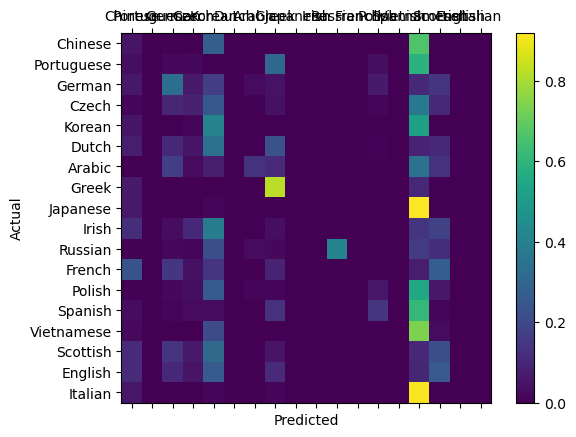

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))

    return output

n_confusion = 10000  # Number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

# Normalizing the confusion matrix
for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plotting the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

# Setting the x-axis and y-axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Setting the tick labels
ax.set_xticklabels([''] + all_categories)
ax.set_yticklabels([''] + all_categories)

# Setting the tick positions
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

# Displaying the plot
plt.show()

In [33]:
from tabulate import tabulate

confusion_matrix = confusion_lstm.numpy()

headers = [''] + all_categories
table = []
for i in range(n_categories):
    row = [all_categories[i]] + confusion_matrix[i].tolist()
    table.append(row)

print(tabulate(table, headers, tablefmt="pipe"))



|            |    Chinese |   Portuguese |     German |      Czech |    Korean |   Dutch |     Arabic |     Greek |   Japanese |   Irish |    Russian |   French |     Polish |   Spanish |   Vietnamese |   Scottish |   English |   Italian |
|:-----------|-----------:|-------------:|-----------:|-----------:|----------:|--------:|-----------:|----------:|-----------:|--------:|-----------:|---------:|-----------:|----------:|-------------:|-----------:|----------:|----------:|
| Chinese    | 0.0498155  |            0 | 0.00369004 | 0          | 0.276753  |       0 | 0          | 0         |          0 |       0 | 0          |        0 | 0          |         0 |    0.664207  | 0.00553506 |         0 |         0 |
| Portuguese | 0.0337302  |            0 | 0.0198413  | 0.0198413  | 0         |       0 | 0          | 0.305556  |          0 |       0 | 0          |        0 | 0.0337302  |         0 |    0.587302  | 0          |         0 |         0 |
| German     | 0.0591304  |            0

In [35]:
from tabulate import tabulate

confusion_matrix = confusion_lstm.numpy()

headers = [''] + all_categories
table = []
for i in range(n_categories):
    row = [all_categories[i]] + confusion_matrix[i].tolist()
    table.append(row)

print(tabulate(table, headers, tablefmt="grid"))

+------------+------------+--------------+------------+------------+-----------+---------+------------+-----------+------------+---------+------------+----------+------------+-----------+--------------+------------+-----------+-----------+
|            |    Chinese |   Portuguese |     German |      Czech |    Korean |   Dutch |     Arabic |     Greek |   Japanese |   Irish |    Russian |   French |     Polish |   Spanish |   Vietnamese |   Scottish |   English |   Italian |
+============+============+==============+============+============+===========+=========+============+===========+============+=========+============+==========+============+===========+==============+============+===========+===========+
| Chinese    | 0.0498155  |            0 | 0.00369004 | 0          | 0.276753  |       0 | 0          | 0         |          0 |       0 | 0          |        0 | 0          |         0 |    0.664207  | 0.00553506 |         0 |         0 |
+------------+------------+-------------

/tmp/ipykernel_14714/3204397704.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_14714/3204397704.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


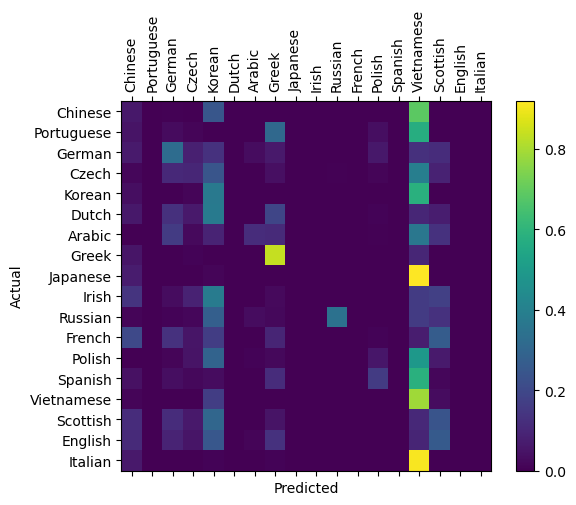

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))

    return output

n_confusion = 10000  # Number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

# Normalizing the confusion matrix
for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plotting the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

# Setting the x-axis and y-axis labels
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# Setting the tick labels
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Setting the tick positions
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))

# Displaying the plot
plt.show()


In [49]:
# def calculate_accuracy():
#     correct = 0
#     total = 0

#     with torch.no_grad():
#         for category in all_categories:
#             category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
#             for line in category_lines[category]:
#                 line_tensor = lineToTensor(line)
#                 output = lstm(line_tensor)
#                 _, predicted_category = categoryFromOutput(output)

#                 if predicted_category == category_tensor.item():
#                     correct += 1

#                 total += 1

#     accuracy = correct / total
#     return accuracy

# accuracy_lstm = calculate_accuracy()
# print("Accuracy of the LSTM model: {:.2%}".format(accuracy_lstm))


In [48]:
# from sklearn.metrics import classification_report

# def generate_classification_report():
#     y_true = []
#     y_pred = []

#     with torch.no_grad():
#         for category in all_categories:
#             category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
#             for line in category_lines[category]:
#                 line_tensor = lineToTensor(line)
#                 output = lstm(line_tensor)
#                 _, predicted_category = categoryFromOutput(output)

#                 y_true.append(all_categories.index(category))  # Convert label to integer
#                 y_pred.append(predicted_category)

#     report = classification_report(y_true, y_pred, target_names=all_categories)
#     return report

# report_lstm = generate_classification_report()
# print("Classification Report for the LSTM model:")
# print(report_lstm)


In [47]:
from sklearn.metrics import classification_report, accuracy_score
# Lists to store predicted and true labels for LSTM
predicted_lstm = []
true_labels_lstm = []

# Lists to store predicted and true labels for MomentumLSTM
predicted_momentum_lstm = []


# Evaluation loop for LSTM
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_lstm = evaluate_lstm(line_tensor)
    guess_lstm, _ = categoryFromOutput(output_lstm)
    predicted_lstm.append(guess_lstm)
    true_labels_lstm.append(category)


# Print classification report and accuracy for LSTM
print("LSTM Performance:")
print(classification_report(true_labels_lstm, predicted_lstm))
print("Accuracy:", accuracy_score(true_labels_lstm, predicted_lstm))



LSTM Performance:
              precision    recall  f1-score   support

      Arabic       0.54      0.10      0.17       554
     Chinese       0.06      0.07      0.06       553
       Czech       0.15      0.10      0.12       547
       Dutch       0.00      0.00      0.00       580
     English       0.00      0.00      0.00       592
      French       0.00      0.00      0.00       551
      German       0.28      0.34      0.30       560
       Greek       0.43      0.85      0.57       523
       Irish       0.00      0.00      0.00       543
     Italian       0.00      0.00      0.00       577
    Japanese       0.00      0.00      0.00       572
      Korean       0.09      0.34      0.14       510
      Polish       0.15      0.05      0.07       550
  Portuguese       0.00      0.00      0.00       531
     Russian       0.99      0.40      0.57       556
    Scottish       0.17      0.25      0.20       594
     Spanish       0.00      0.00      0.00       556
  Vietnam

/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = lstm(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Yuan')
predict('Jackson')
predict('Satoshi')



> Yuan
(6.05) Chinese
(4.93) Korean
(2.32) Dutch

> Jackson
(6.86) Scottish
(6.34) English
(4.12) Czech

> Satoshi
(5.05) Italian
(4.92) Japanese
(4.79) Arabic


/tmp/ipykernel_14714/397336805.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_14714/397336805.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


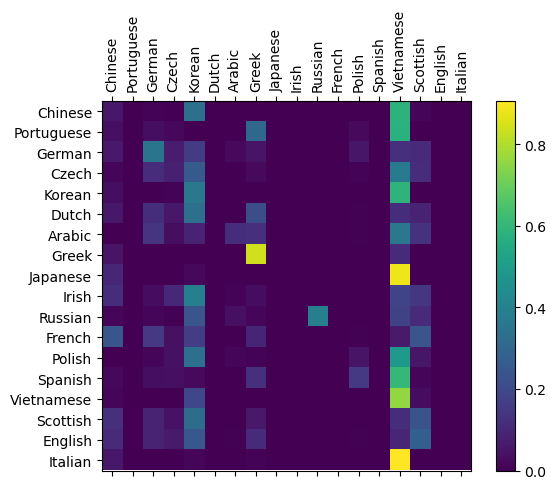

In [20]:
import matplotlib.ticker as ticker

# Initializing the confusion matrix
confusion_lstm = torch.zeros(n_categories, n_categories)

def evaluate_lstm(line_tensor):
    hidden = None  # Initialize hidden state for LSTM

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i].unsqueeze(0))

    return output

n_confusion = 10000  # Defining the number of samples for the confusion matrix

for i in range(n_confusion):
    _, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = category_tensor.item()
    confusion_lstm[category_i][guess_i] += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

# Plotting the confusion matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_lstm.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()



In [36]:
"""
Step 3. Creating the Network MomentumLSTM
"""
import torch.nn as nn
import torch.nn.init as init

class MomentumLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MomentumLSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Initialize momentum variables
        self.momentum_lstm_ih = torch.zeros_like(self.lstm.weight_ih_l0)
        self.momentum_lstm_hh = torch.zeros_like(self.lstm.weight_hh_l0)
        self.momentum_fc = torch.zeros_like(self.fc.weight)

        # Initialize weights using Xavier initialization
        for name, param in self.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)

    def forward(self, input, hidden):
        lstm_out, hidden = self.lstm(input, hidden)
        output = self.fc(lstm_out[-1])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size=1):
        device = next(self.parameters()).device
        return (torch.zeros(1, batch_size, self.hidden_size).to(device),
                torch.zeros(1, batch_size, self.hidden_size).to(device))
    
# Creating an instance of MomentumLSTM
momentum_lstm = MomentumLSTM(n_letters, n_hidden, n_categories)


In [38]:
# Define the optimizer with momentum for MomentumLSTM
optimizer_lstm = optim.SGD(momentum_lstm.parameters(), lr=learning_rate, momentum=0.9)

# Training loop with momentum optimization for MomentumLSTM
def train_momentum_lstm(category_tensor, line_tensor):
    momentum_lstm.zero_grad()

    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_lstm(line_tensor[i].unsqueeze(0), hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Apply gradient clipping
    torch.nn.utils.clip_grad_norm_(momentum_lstm.parameters(), max_norm=1.0)

    optimizer_lstm.step()

    return output, loss.item()

# Training the MomentumLSTM
momentum_lstm_losses = []
current_loss = 0
start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_momentum_lstm(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        momentum_lstm_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 16s) 2.2139 Slaski / Czech ✗ (Polish)
10000 10% (0m 34s) 2.3201 Michel / English ✗ (French)
15000 15% (0m 49s) 0.2375 Takemura / Japanese ✓
20000 20% (1m 5s) 2.6142 Abel / German ✗ (Spanish)
25000 25% (1m 23s) 0.0638 Krakowski / Polish ✓
30000 30% (1m 40s) 0.0102 Miyahara / Japanese ✓
35000 35% (2m 1s) 0.3940 Samios / Greek ✓
40000 40% (2m 18s) 1.2600 Maria / Arabic ✗ (Portuguese)
45000 45% (2m 36s) 0.1117 Henderson / Scottish ✓
50000 50% (2m 54s) 2.1012 Cabral / Irish ✗ (Portuguese)
55000 55% (3m 11s) 2.1375 Winman / Scottish ✗ (English)
60000 60% (3m 29s) 0.7484 Bellerose / French ✓
65000 65% (3m 46s) 0.0528 Peusen / Dutch ✓
70000 70% (4m 3s) 0.4373 Cavallo / Italian ✓
75000 75% (4m 20s) 1.1771 Mustafa / Japanese ✗ (Arabic)
80000 80% (4m 37s) 11.6972 Comino / Italian ✗ (Greek)
85000 85% (4m 55s) 5.8605 Day / Vietnamese ✗ (English)
90000 90% (5m 14s) 0.4168 Ma / Vietnamese ✓
95000 95% (5m 33s) 0.0069 Vasquez / Spanish ✓
100000 100% (5m 49s) 0.1412 Gorecki / Polish ✓


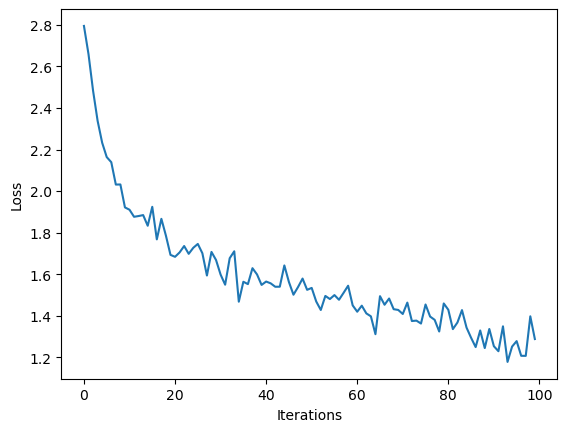

In [39]:
plt.figure()
plt.plot(momentum_lstm_losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

/tmp/ipykernel_14714/1523369039.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_14714/1523369039.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


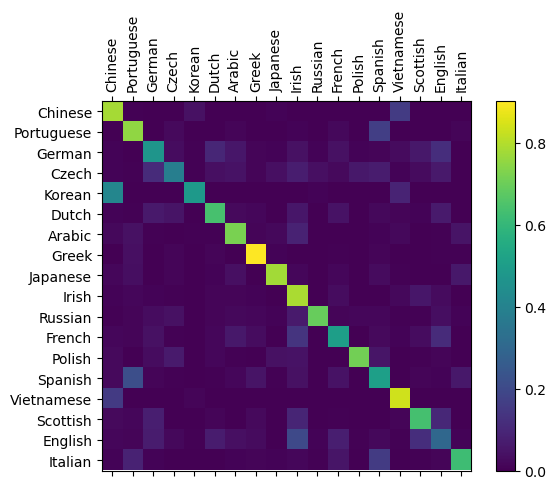

In [43]:
# Evaluating the network and create a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate_momentum_lstm(line_tensor):
    hidden = momentum_lstm.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = momentum_lstm(line_tensor[i].unsqueeze(0), hidden)

    return output

# Going through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate_momentum_lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalizing by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Setting up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Setting up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()


In [51]:

# plt.figure()
# plt.plot(lstm_losses, label='LSTM')
# plt.plot(momentum_lstm_losses, label='MomentumLSTM')
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.legend()

# plt.show()

In [45]:
from sklearn.metrics import classification_report, accuracy_score
# Lists to store predicted and true labels for LSTM
predicted_lstm = []
true_labels_lstm = []

# Lists to store predicted and true labels for MomentumLSTM
predicted_momentum_lstm = []
true_labels_momentum_lstm = []

# Evaluation loop for LSTM
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_lstm = evaluate_lstm(line_tensor)
    guess_lstm, _ = categoryFromOutput(output_lstm)
    predicted_lstm.append(guess_lstm)
    true_labels_lstm.append(category)

# Evaluation loop for MomentumLSTM
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output_momentum_lstm = evaluate_momentum_lstm(line_tensor)
    guess_momentum_lstm, _ = categoryFromOutput(output_momentum_lstm)
    predicted_momentum_lstm.append(guess_momentum_lstm)
    true_labels_momentum_lstm.append(category)

# Print classification report and accuracy for LSTM
print("LSTM Performance:")
print(classification_report(true_labels_lstm, predicted_lstm))
print("Accuracy:", accuracy_score(true_labels_lstm, predicted_lstm))

# Print classification report and accuracy for MomentumLSTM
print("MomentumLSTM Performance:")
print(classification_report(true_labels_momentum_lstm, predicted_momentum_lstm))
print("Accuracy:", accuracy_score(true_labels_momentum_lstm, predicted_momentum_lstm))


LSTM Performance:
              precision    recall  f1-score   support

      Arabic       0.67      0.13      0.22       544
     Chinese       0.06      0.06      0.06       555
       Czech       0.15      0.09      0.11       583
       Dutch       0.00      0.00      0.00       612
     English       0.00      0.00      0.00       557
      French       0.00      0.00      0.00       538
      German       0.24      0.28      0.26       543
       Greek       0.44      0.84      0.58       624
       Irish       0.00      0.00      0.00       546
     Italian       0.00      0.00      0.00       556
    Japanese       0.00      0.00      0.00       516
      Korean       0.09      0.35      0.15       510
      Polish       0.15      0.05      0.08       563
  Portuguese       0.00      0.00      0.00       511
     Russian       0.99      0.38      0.55       552
    Scottish       0.13      0.21      0.16       565
     Spanish       0.00      0.00      0.00       575
  Vietnam

/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/song/anaconda3/envs/Action/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

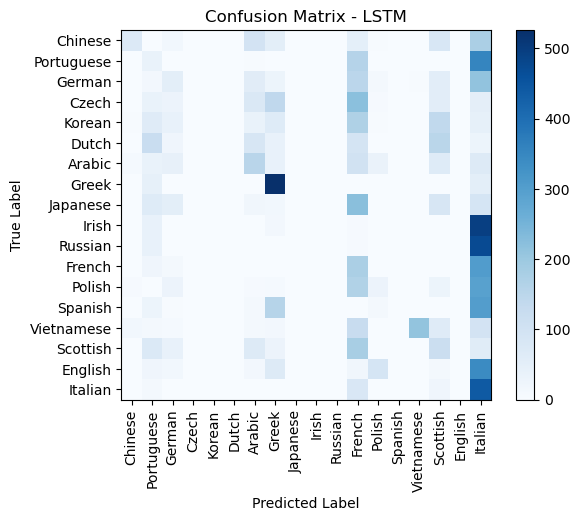

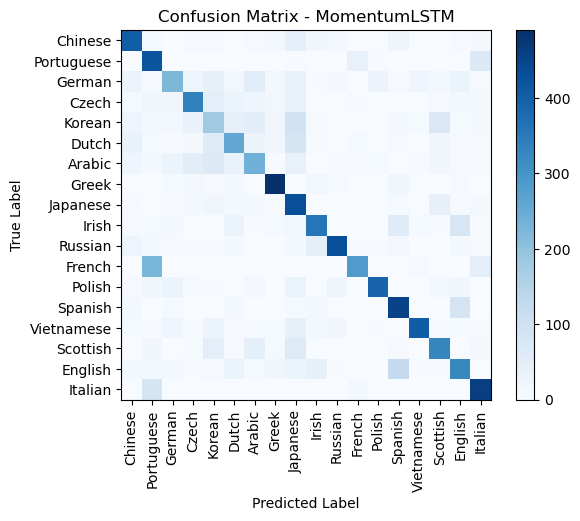

In [46]:
from sklearn.metrics import confusion_matrix

# Evaluating LSTM model and create a confusion matrix
lstm_confusion = confusion_matrix(true_labels_lstm, predicted_lstm)

# Evaluating MomentumLSTM model and create a confusion matrix
momentum_lstm_confusion = confusion_matrix(true_labels_momentum_lstm, predicted_momentum_lstm)

# Ploting the LSTM confusion matrix
plt.figure()
plt.imshow(lstm_confusion, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - LSTM')

# Ploting the MomentumLSTM confusion matrix
plt.figure()
plt.imshow(momentum_lstm_confusion, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MomentumLSTM')

plt.show()
